# 과적합 해결

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets

### 배치 정규화 적용

In [2]:
# 데이터셋 로드
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

In [3]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_data, val_data = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

In [4]:
class SimpleNN(nn.Module):
    def __init__(self, use_bn=False):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.bn1 = nn.BatchNorm1d(128) if use_bn else nn.Identity()
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64) if use_bn else nn.Identity()
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)   # (배치 크기, h, w) -> (배치 크기, feature)
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [5]:
def train(model, train_loader, val_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()

        print(f'Epoch {epoch + 1} | Val Loss: {val_loss / len(val_loader):.4f}, Accuracy: {correct / len(val_data):.4f}')

In [6]:
print("배치 정규화 적용 안함")
model_without_bn = SimpleNN(use_bn=False)
train(model_without_bn, train_loader, val_loader)

print()
print("배치 정규화 적용")
model_with_bn = SimpleNN(use_bn=True)
train(model_with_bn, train_loader, val_loader)

배치 정규화 적용 안함
Epoch 1 | Val Loss: 0.2786, Accuracy: 0.9163
Epoch 2 | Val Loss: 0.2053, Accuracy: 0.9369
Epoch 3 | Val Loss: 0.1720, Accuracy: 0.9497
Epoch 4 | Val Loss: 0.1580, Accuracy: 0.9538
Epoch 5 | Val Loss: 0.1366, Accuracy: 0.9582

배치 정규화 적용
Epoch 1 | Val Loss: 0.1225, Accuracy: 0.9644
Epoch 2 | Val Loss: 0.1044, Accuracy: 0.9692
Epoch 3 | Val Loss: 0.0938, Accuracy: 0.9704
Epoch 4 | Val Loss: 0.0845, Accuracy: 0.9741
Epoch 5 | Val Loss: 0.0900, Accuracy: 0.9748


In [7]:
for batch_size in [16, 32, 128]:
    print(f"batch size: {batch_size}")
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    model = SimpleNN(use_bn=True)
    train(model, train_loader, val_loader)

batch size: 16
Epoch 1 | Val Loss: 0.1243, Accuracy: 0.9620
Epoch 2 | Val Loss: 0.1004, Accuracy: 0.9703
Epoch 3 | Val Loss: 0.0884, Accuracy: 0.9752
Epoch 4 | Val Loss: 0.0801, Accuracy: 0.9765
Epoch 5 | Val Loss: 0.0781, Accuracy: 0.9758
batch size: 32
Epoch 1 | Val Loss: 0.1241, Accuracy: 0.9643
Epoch 2 | Val Loss: 0.1026, Accuracy: 0.9687
Epoch 3 | Val Loss: 0.0894, Accuracy: 0.9738
Epoch 4 | Val Loss: 0.0867, Accuracy: 0.9742
Epoch 5 | Val Loss: 0.0829, Accuracy: 0.9758
batch size: 128
Epoch 1 | Val Loss: 0.1449, Accuracy: 0.9588
Epoch 2 | Val Loss: 0.1073, Accuracy: 0.9670
Epoch 3 | Val Loss: 0.0950, Accuracy: 0.9710
Epoch 4 | Val Loss: 0.0886, Accuracy: 0.9726
Epoch 5 | Val Loss: 0.0837, Accuracy: 0.9747


### 드롭아웃 적용

In [8]:
class DropoutNN(nn.Module):
    def __init__(self, dropout_rate):
        super(DropoutNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.dropout1(self.fc1(x)))
        x = torch.relu(self.dropout2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [9]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

for rate in [0.2, 0.5, 0.8]:
    print(f"Dropout Rate: {rate}")
    model = DropoutNN(dropout_rate=rate)
    train(model, train_loader, val_loader)

Dropout Rate: 0.2
Epoch 1 | Val Loss: 0.2613, Accuracy: 0.9222
Epoch 2 | Val Loss: 0.1871, Accuracy: 0.9420
Epoch 3 | Val Loss: 0.1562, Accuracy: 0.9533
Epoch 4 | Val Loss: 0.1353, Accuracy: 0.9607
Epoch 5 | Val Loss: 0.1391, Accuracy: 0.9593
Dropout Rate: 0.5
Epoch 1 | Val Loss: 0.3472, Accuracy: 0.8969
Epoch 2 | Val Loss: 0.3063, Accuracy: 0.9090
Epoch 3 | Val Loss: 0.2728, Accuracy: 0.9193
Epoch 4 | Val Loss: 0.2494, Accuracy: 0.9248
Epoch 5 | Val Loss: 0.2386, Accuracy: 0.9322
Dropout Rate: 0.8
Epoch 1 | Val Loss: 1.3702, Accuracy: 0.6590
Epoch 2 | Val Loss: 1.3102, Accuracy: 0.7127
Epoch 3 | Val Loss: 1.3017, Accuracy: 0.6651
Epoch 4 | Val Loss: 1.2702, Accuracy: 0.6716
Epoch 5 | Val Loss: 1.3209, Accuracy: 0.6530


In [10]:
model = DropoutNN(dropout_rate=0.2)

In [11]:
model.eval()
with torch.no_grad():
    images, _ = next(iter(val_loader))
    images = images.view(images.size(0), -1)

    out1 = model(images)
    out2 = model(images)

    print(torch.allclose(out1, out2))

True


In [12]:
model.train()

out1 = model(images)
out2 = model(images)

print(torch.allclose(out1, out2))

False


### Learning Rate Scheduler 적용

In [13]:
class RealSimpleNN(nn.Module):
    def __init__(self):
        super(RealSimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [14]:
def train_lr(model, train_loader, val_loader, optimizer, scheduler, epochs=10):
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()

        scheduler.step()
        print(f'Epoch {epoch + 1} | Val Loss: {val_loss / len(val_loader):.4f}, Accuracy: {correct / len(val_data):.4f}')

In [15]:
model = RealSimpleNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

train_lr(model, train_loader, val_loader, optimizer, scheduler)

Epoch 1 | Val Loss: 0.3008, Accuracy: 0.9113
Epoch 2 | Val Loss: 0.2606, Accuracy: 0.9248
Epoch 3 | Val Loss: 0.2436, Accuracy: 0.9323
Epoch 4 | Val Loss: 0.1678, Accuracy: 0.9521
Epoch 5 | Val Loss: 0.1630, Accuracy: 0.9532
Epoch 6 | Val Loss: 0.1585, Accuracy: 0.9548
Epoch 7 | Val Loss: 0.1517, Accuracy: 0.9583
Epoch 8 | Val Loss: 0.1512, Accuracy: 0.9586
Epoch 9 | Val Loss: 0.1506, Accuracy: 0.9585
Epoch 10 | Val Loss: 0.1503, Accuracy: 0.9583


### 조기 종료

In [16]:
def train_es(model, train_loader, val_loader, optimizer, epochs=50, early_stopping=None):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_data)

        print(f'Epoch {epoch + 1} | Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

        if early_stopping and early_stopping(val_loss):
            print(f'조기 종료 epoch {epoch + 1}')
            break

    return train_losses, val_losses    

In [17]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1

        return self.counter >= self.patience

In [18]:
model_no_es = RealSimpleNN()
optim_no_es = optim.Adam(model_no_es.parameters(), lr=0.01)
train_losses, val_losses = train_es(model_no_es, train_loader, val_loader, 
                                    optim_no_es)

model_es = RealSimpleNN()
optim_es = optim.Adam(model_es.parameters(), lr=0.01)
early_stopping = EarlyStopping(patience=5)
train_es_losses, val_es_losses = train_es(model_es, train_loader, val_loader, 
                                          optim_es, early_stopping=early_stopping)

Epoch 1 | Val Loss: 0.3154, Accuracy: 0.9026
Epoch 2 | Val Loss: 0.2788, Accuracy: 0.9246
Epoch 3 | Val Loss: 0.2617, Accuracy: 0.9256
Epoch 4 | Val Loss: 0.2706, Accuracy: 0.9208
Epoch 5 | Val Loss: 0.2585, Accuracy: 0.9274
Epoch 6 | Val Loss: 0.2908, Accuracy: 0.9238
Epoch 7 | Val Loss: 0.2180, Accuracy: 0.9409
Epoch 8 | Val Loss: 0.2368, Accuracy: 0.9423
Epoch 9 | Val Loss: 0.2283, Accuracy: 0.9425
Epoch 10 | Val Loss: 0.2276, Accuracy: 0.9414
Epoch 11 | Val Loss: 0.2230, Accuracy: 0.9437
Epoch 12 | Val Loss: 0.2181, Accuracy: 0.9440
Epoch 13 | Val Loss: 0.2419, Accuracy: 0.9377
Epoch 14 | Val Loss: 0.2463, Accuracy: 0.9370
Epoch 15 | Val Loss: 0.2567, Accuracy: 0.9387
Epoch 16 | Val Loss: 0.2155, Accuracy: 0.9443
Epoch 17 | Val Loss: 0.2137, Accuracy: 0.9456
Epoch 18 | Val Loss: 0.1946, Accuracy: 0.9536
Epoch 19 | Val Loss: 0.2180, Accuracy: 0.9457
Epoch 20 | Val Loss: 0.2230, Accuracy: 0.9480
Epoch 21 | Val Loss: 0.2299, Accuracy: 0.9476
Epoch 22 | Val Loss: 0.2961, Accuracy: 0.93

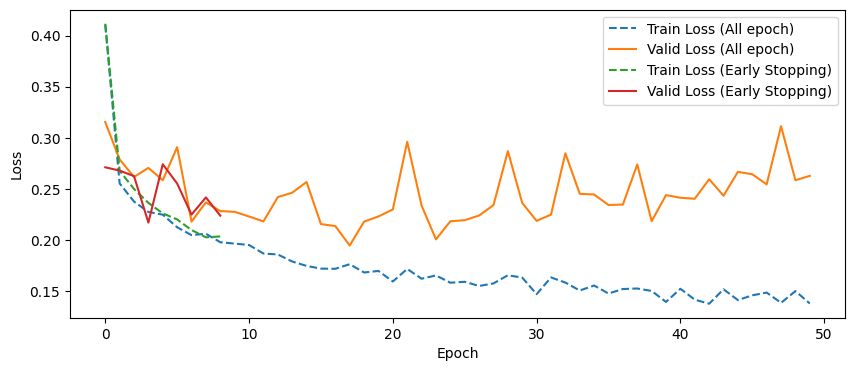

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss (All epoch)', linestyle='dashed')
plt.plot(val_losses, label='Valid Loss (All epoch)')
plt.plot(train_es_losses, label='Train Loss (Early Stopping)', linestyle='dashed')
plt.plot(val_es_losses, label='Valid Loss (Early Stopping)')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### L2 적용

In [20]:
def train_reg(model, train_loader, val_loader, optimizer, epochs=50):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []
    weight_norms = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
            val_loss /= len(val_loader)
            val_losses.append(val_loss)
            accuracy = correct / len(val_data)
            
            print(f'Epoch {epoch + 1} | Val Loss: {val_losses}, Accuracy: {accuracy:.4f}')
        
            weight_norm = sum(torch.norm(p).item() for p in model.parameters())
            weight_norms.append(weight_norm)
                    
        return train_losses, val_losses

In [21]:
model_no_reg = RealSimpleNN()
optim_no_reg = optim.SGD(model_no_reg.parameters(), lr=0.01, weight_decay=0.0, momentum=0.9)
train_losses, val_losses, weight_norms = train_reg(model_no_reg, train_loader, val_loader, optim_no_reg)

model_reg = RealSimpleNN()
optim_reg = optim.SGD(model_reg.parameters(), lr=0.01, weight_decay=0.01, momentum=0.9)
train_reg_losses, val_reg_losses, weight_norms_reg = train_reg(model_reg, train_loader, val_loader, optim_reg)


Epoch 1 | Val Loss: [0.24945339923130072], Accuracy: 0.9238


ValueError: not enough values to unpack (expected 3, got 2)